## Complete experiment: Simple Recon, No Motion

In [1]:
## imports

import numpy as np
import cupy as cp
import numpy.fft as fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage
import scipy.interpolate
from numpy.fft import fftshift, ifftshift, ifft2
import sigpy as sp
from sigpy.mri import dcf
from sigpy.mri.samp import radial
from tqdm.notebook import tqdm
import sigpy.plot as pl
import gc
import cupy as cp
from scipy.ndimage import map_coordinates
import cupy as cp
import numpy as np
from tqdm import tqdm


### 1. Create 2d Object

In [2]:
def create_cylinder_mm(radius, matrix_size, height=0, fov=None):
    '''Create cylinder of radius, height centered at matrix_size'''
    Nz, Ny, Nx = matrix_size

    if fov==None:
        fov = max(2.5*2*radius, 1.5*height)

    ## Calculate voxel sizes based on FOV
    if height==0:
        voxel_size_z = 0
    else:
        voxel_size_z = fov / Nz

    voxel_size_x = fov / Nx
    voxel_size_y = fov / Ny
    print(f'voxel_size_z, voxel_size_y, voxel_size_x = [{voxel_size_z, voxel_size_y, voxel_size_x}]')

    ## Set up x, y ,z so that it goes from -Nx to +Nx (and respective Ny, Nz)
    x = (np.arange(Nx) - Nx//2) * voxel_size_x
    y = (np.arange(Ny) - Ny//2) * voxel_size_y 
    z = (np.arange(Nz) - Nz//2) * voxel_size_z 

    ## Create meshgrid, acts as image space ith voxels
    zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')
    positions = np.vstack([zz.ravel(), yy.ravel(), xx.ravel()])
    
    ## distance from center in xy plane
    rr = np.sqrt(xx**2 + yy**2)
    print(rr.shape)

    cylinder = np.logical_and(rr <= radius, 
                              np.abs(zz) <= height//2 ).astype(float)
    
    fov = max(2.5*2*radius, 1.5*height)
    cylinder = np.squeeze(cylinder)
    return cylinder, fov, positions, voxel_size_x


def create_cylinder_with_objects_mm(radius, matrix_size, height=0, fov=None, add_objects=True):
    '''Create OG cylinder but add small objects for artifact visualization'''
    cylinder, fov, positions, voxel_size_x = create_cylinder_mm(radius, matrix_size, height, fov)
    
    if add_objects:
        Nz, Ny, Nx = matrix_size
        if height == 0:
            voxel_size_z = 0
        else:
            voxel_size_z = fov / Nz
        voxel_size_x = fov / Nx
        voxel_size_y = fov / Ny
        

        x = (np.arange(Nx) - Nx//2) * voxel_size_x
        y = (np.arange(Ny) - Ny//2) * voxel_size_y
        z = (np.arange(Nz) - Nz//2) * voxel_size_z
        zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')
        
        # Array to store objects
        objects = []
        
        # Small circle upper right
        obj1_center = (radius * 0.5, radius * 0.5)
        obj1_radius = radius * 0.1
        obj1_mask = (xx - obj1_center[0])**2 + (yy - obj1_center[1])**2 <= obj1_radius**2
        objects.append(('circle1', obj1_mask, 0.7))  # Intensity 0.7
        
        # Small rectangle near center
        obj3_width = radius * 0.15
        obj3_height = radius * 0.05
        obj3_center = (radius * 0.1, -radius * 0.1)
        obj3_mask = (np.abs(xx - obj3_center[0]) <= obj3_width/2) & (np.abs(yy - obj3_center[1]) <= obj3_height/2)
        objects.append(('rectangle', obj3_mask, 0.5))  # Set intensity = 0.5
        
        # Thin line 
        obj4_mask = (np.abs(xx + radius * 0.2) <= radius * 0.02) & (np.abs(yy) <= radius * 0.3)
        objects.append(('line', obj4_mask, 1.5))  # Set intensity 1.5
        
        # add objects where they exist and cylinder is nonzero, else just return cylinder
        for obj_name, obj_mask, intensity in objects:
            cylinder = np.where(obj_mask & (cylinder > 0), intensity, cylinder)
    
    cylinder = np.squeeze(cylinder)
    return cylinder, fov, positions, voxel_size_x


def show_2d_cylinder(c):
    plt.figure(1)
    plt.imshow(c, cmap='gray')
    plt.title("2D Image of 2d Cylinder")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.colorbar(label="Intensity")
    plt.savefig('og_2d_cylinder.png')
    plt.show()




### 2. Create Radial Trajectory

In [3]:
def center_out_GA_radial(ntr, nro, ndims, img_size, fov_orig):
    '''Create center-out golden-angle radial trajectory using Sigpy
    
    Inputs
    ----------------------
    ntr (int): Number of repetitions = number of spokes collected
    nro (int) : Number of readout points = number of ksp samples per spoke
    ndims (int): Number of kspace dimensions
    img_size (tuple) : (Nx, Ny) size of image
      
    '''
    coord_shape = (ntr, nro, ndims)
    if ndims != len(img_size):
        Warning("K-space dimensions not equal to image dimensions")
    else:
        radial_coords_pixel = radial(coord_shape, img_size, golden=True)
        radial_coords_physical = radial_coords_pixel/fov_orig
        return radial_coords_pixel, radial_coords_physical


def plot_GA_trajectory(radial_coords_pixel):
    num_spokes = radial_coords_pixel.shape[0]
    for i in range(num_spokes):
        plt.plot(radial_coords_pixel[i,:,0], radial_coords_pixel[i,:,1])
    plt.title(f"Center-out Radial Trajectory with {num_spokes} spokes")
    plt.savefig(f'radial_coords_{num_spokes}sp.png')
    plt.show()

### 3. Timing + Motion Information

In [4]:
def get_acq_times(num_spokes, total_scan_time=1.0):
    '''Assign time point to each spoke'''
    acq_times = np.linspace(0, total_scan_time, num_spokes)
    return acq_times


def sinusoidal_motion(t, amplitude, frequency, direction='x'):
    '''Calculate position offset due to sinusoidal motion
    
    Inputs
    ------------------------
    t : time points (s)
    amplitude: motion amplitude (mm)
    frequency: motion frequency (Hz)
    direction: 'x' , 'y', 'xy'
    '''

    displacement = amplitude*np.sin(2*np.pi*frequency*t)

    if direction=='x':
        return displacement, 0
    elif direction=='y':
        return 0, displacement
    elif direction=='xy':
        return displacement, displacement
    else:
        return 0,0
    

### 3.5. Plot Motion over Time

In [5]:
def plot_motion_over_time(ntr, motion_params, num_point=1000):
    acq_times = get_acq_times(ntr, motion_params['scan_time'])
    dx_array, dy_array = [], []

    for t in acq_times:
        dx, dy = sinusoidal_motion(t, motion_params['amplitude'], motion_params['frequency'], motion_params['direction'])
        dx_array.append(dx)
        dy_array.append(dy)

    dx_array = np.array(dx_array)
    dy_array = np.array(dy_array)

    plt.figure(1)
    plt.plot(acq_times, dx_array, 'b-', linewidth=2, label="X displacement")
    plt.plot(acq_times, dy_array, 'r-', linewidth=2, label="Y displacement")
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (mm)")
    plt.legend()
    plt.grid(True)
    plt.title("Phantom Dynamics: Motion vs Time")
    plt.savefig(f"motion_v_time_amp{motion_params['amplitude']}_freq{motion_params['frequency']}_dir{motion_params['direction']}.png")
    plt.show()

### 4. Fourier Encoding of object

In [6]:
import cupy as cp
import numpy as np
from tqdm import tqdm


def fourier_encoding_radial_motion_gpu(radial_coords, cylinder_orig, fov_orig, 
                                     upsamp, orig_size, motion_params=None):
    # Move data to GPU
    kx_coords_gpu = cp.asarray(radial_coords[..., 1])
    ky_coords_gpu = cp.asarray(radial_coords[..., 0])
    
    num_spokes = radial_coords.shape[0]
    num_points = radial_coords.shape[1]
    grid_size = int(upsamp * orig_size)
    
    x_pos_base = cp.linspace(-fov_orig/2, fov_orig/2, grid_size)
    y_pos_base = cp.linspace(-fov_orig/2, fov_orig/2, grid_size)
    
    # Move cylinder to GPU
    pad_size = (grid_size - orig_size) // 2
    cylinder_padded_cpu = np.pad(cylinder_orig, 
                                ((pad_size, pad_size), (pad_size, pad_size)),
                                mode='constant', constant_values=0)
    cylinder_padded_gpu = cp.asarray(cylinder_padded_cpu)
    
    S_gpu = cp.zeros((num_spokes, num_points), dtype=cp.complex64)

    if motion_params is not None:
        acq_times = get_acq_times(num_spokes, motion_params['scan_time'])
    
    # Process spoke by spoke
    for spoke in tqdm(range(num_spokes), desc='Processing spokes (with motion) on GPU'):
        kx_spoke = kx_coords_gpu[spoke, :]
        ky_spoke = ky_coords_gpu[spoke, :]

        ## Every time we acquire a spoke, assume object has been affected by motion
        if motion_params is not None:
            t = acq_times[spoke]
            dx, dy = sinusoidal_motion(t, motion_params['amplitude'],
                                       motion_params['frequency'],
                                       motion_params['direction'])
            
            ## Shift coordinates by motion
            x_pos = x_pos_base + dx
            y_pos =  y_pos_base + dy
        else:
            x_pos = x_pos_base
            y_pos = y_pos_base

        X_gpu, Y_gpu = cp.meshgrid(x_pos, y_pos)
        # Compute all encoding patterns for this spoke on GPU
        F_all = cp.exp(-1j * 2 * cp.pi * (
            kx_spoke[:, None, None] * X_gpu[None, :, :] + 
            ky_spoke[:, None, None] * Y_gpu[None, :, :]
        ))
        
        # Compute inner products on GPU
        S_gpu[spoke, :] = cp.sum(cylinder_padded_gpu[None, :, :] * F_all, axis=(1, 2))
    
    # Move result back to CPU
    S = cp.asnumpy(S_gpu)
    return S



def fourier_encoding_cartesian_motion_gpu(matrix_size, cylinder_orig, fov_orig, upsamp, orig_size, motion_params=None):
    # Move data to GPU
    grid_size = int(upsamp * orig_size)
    S_gpu = cp.zeros((grid_size, grid_size), dtype=cp.complex64)
    Nx, Ny = grid_size, grid_size

    dkx = 1/fov_orig
    dky = 1/fov_orig
    
    x_pos = cp.linspace(-fov_orig/2, fov_orig/2, grid_size)
    y_pos= cp.linspace(-fov_orig/2, fov_orig/2, grid_size)
    X_gpu, Y_gpu = cp.meshgrid(x_pos, y_pos, indexing='ij')
    
    # Move cylinder to GPU
    pad_size = (grid_size - orig_size) // 2
    cylinder_padded_cpu = np.pad(cylinder_orig, 
                                ((pad_size, pad_size), (pad_size, pad_size)),
                                mode='constant', constant_values=0)
    cylinder_padded_gpu = cp.asarray(cylinder_padded_cpu)

    if motion_params is not None:
        acq_times = get_acq_times(Ny, motion_params['scan_time'])
    
    
    # Process line by line
    for ky_idx in range(0, Ny):


        if motion_params is not None:
            t = acq_times[ky_idx]
            dx, dy = sinusoidal_motion(t, motion_params['amplitude'], motion_params['frequency'], motion_params['direction'])

        else:
            dx, dy = 0, 0

        x_pos = cp.linspace(-fov_orig/2, fov_orig/2, grid_size) + dx
        y_pos= cp.linspace(-fov_orig/2, fov_orig/2, grid_size) + dy
        X, Y = cp.meshgrid(x_pos, y_pos, indexing='ij')

        n_ky = (ky_idx - Ny//2) * dky
    
        for kx_idx in range(0, Nx):
            n_kx = (kx_idx - Nx//2) * dkx

            # Compute all encoding patterns for this pt on GPU
            F_all = cp.exp(-1j * 2 * cp.pi * (
                n_kx * X[None, :, :] + 
                n_ky * Y[None, :, :]
            ))
            
            # Compute inner products on GPU
            S_gpu[kx_idx, ky_idx] = cp.sum(cylinder_padded_gpu[None, :, :] * F_all, axis=(1, 2))
    
    # Move result back to CPU
    S = cp.asnumpy(S_gpu)
    return S

### 5. NUFFT Reconstruction

In [7]:
def analytical_density_weights(radial_coords):
    """Analytical density compensation for radial sampling"""
    kx = radial_coords[..., 0]
    ky = radial_coords[..., 1]
    kr = np.sqrt(kx**2 + ky**2)
    
    eps = 1e-8

    weights = kr+eps
    
    return weights


def reconstruct_from_2d_radial(radial_coords, radial_coords_physical, ksp_values, fov_orig, img_size):
    # Convert physical k-space units back into pixel units for sigpy
    k_max_for_fov = img_size[0] / (2.0 * fov_orig *1.2788)  # Proper k_max for target FOV

    coords_normalized = radial_coords / (2 * k_max_for_fov)


    ## Flatten trajectory and ksp data
    radial_flat = coords_normalized.reshape(-1, 2) ##keep xy dimension
    ksp_flat = ksp_values.flatten()

    # Apply density compensation
    density_weights = analytical_density_weights(radial_coords_physical)
    ksp_weighted = ksp_flat * density_weights.flatten()

    ## Sanity check
    print(f'Physical coords range: [{radial_coords_physical.min():.1f}, {radial_coords_physical.max():.1f}]')
    print(f'Pixel coords range: [{radial_coords.min():.1f}, {radial_coords.max():.1f}]')
    print(f'Normalized coordinates range: [{coords_normalized.min():.4f}, {coords_normalized.max():.4f}]')
    print(f'Expected pixel range: [-{img_size[0]/2}, {img_size[0]/2}]')  

    # Check what FOV the reconstruction is actually using
    print(f"FOV used in forward encoding: {fov_orig}")
    print(f"Max k-space coordinate: {np.max(np.abs(coords_normalized)):.4f} (1/mm)")
    # print(f"Implied FOV from k-space: {1/(2*np.max(np.abs(k_max_for_fov))):.1f} mm")

    print(f"coords_normalized range: [{coords_normalized.min():.6f}, {coords_normalized.max():.6f}]")
    print(f"Should be approximately: [-0.5, 0.5]")
    
    print(f"Density weights range: {density_weights.min():.3f} to {density_weights.max():.3f}")
    print(f"K-space data range: {ksp_flat.min():.3e} to {ksp_flat.max():.3e}")
    
    ##Create NUFFT operator and reconstruct
    nufft_op = sp.linop.NUFFT(img_size, radial_flat)
    recon_image = nufft_op.H(ksp_weighted)
    
    return np.real(recon_image)

def crop_img(img, crop_size):
    nx, ny = img.shape
    nx_crop, ny_crop = crop_size
    center_x, center_y = nx//2, ny//2
    img_cropped = img[center_x-nx_crop//2:center_x+nx_crop//2, center_y-ny_crop//2:center_y+ny_crop//2]
    return img_cropped

def reconstruct_from_2d_cartesian(ksp_values, final_image_size):
    img = fft.fftshift(fft.fft2(fft.fftshift(ksp_values)))
    img = img /(256*256*4.987)
    cropped_img = crop_img(img, final_image_size)
    return np.abs(np.fliplr(np.flipud(cropped_img)))

def plot_reconstruction(img, motion_params=None, crop_size=None, recon_type='Cartesian'):
    if motion_params is not None:
        title = f"{recon_type} Reconstruction with: amp = {motion_params['amplitude']}, frequency={motion_params['frequency']},\n direction = {motion_params['direction']}, scan time = {motion_params['scan_time']}"
        path = f"recon_img_amp{motion_params['amplitude']}_freq{motion_params['frequency']}_dir{motion_params['direction']}.png"

    else:
        title = f"{recon_type} Reconstruction, no motion"
        path = f"recon_img_{recon_type}.png"
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.savefig(path)

### Comparison Metrics

In [8]:
def calculate_image_metrics(orig, recon):
    """Calculate metrics for image quality assessment"""
    
    
    # Normalize images to same scale
    orig_norm = (orig - orig.min()) / (orig.max() - orig.min())
    recon_norm = (recon - recon.min()) / (recon.max() - recon.min())
    
    # MSE
    mse = np.mean((orig_norm - recon_norm)**2)
    rmse = np.sqrt(mse)
    
    # Peak Signal-to-Noise Ratio
    psnr = 20 * np.log10(1.0 / rmse) if rmse > 0 else float('inf')

    
    # Structural similarity (simplified)
    mean_orig = np.mean(orig_norm)
    mean_recon = np.mean(recon_norm)
    var_orig = np.var(orig_norm)
    var_recon = np.var(recon_norm)
    cov = np.mean((orig_norm - mean_orig) * (recon_norm - mean_recon))
    
    c1, c2 = 0.01**2, 0.03**2  # Constants for stability
    ssim = ((2*mean_orig*mean_recon + c1) * (2*cov + c2)) / \
           ((mean_orig**2 + mean_recon**2 + c1) * (var_orig + var_recon + c2))
    
    return {
        'mse': mse,
        'rmse': rmse, 
        'psnr': psnr,
        'ssim': ssim
    }

###  Basic Implementation

GPU available: True
GPU memory: 0.00 GB
voxel_size_z, voxel_size_y, voxel_size_x = [(0, 0.390625, 0.390625)]
(1, 256, 256)


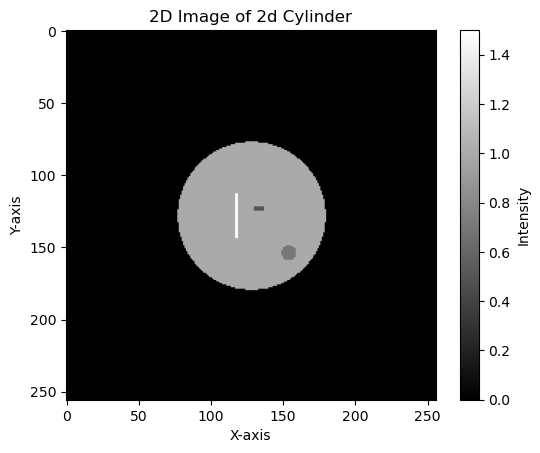

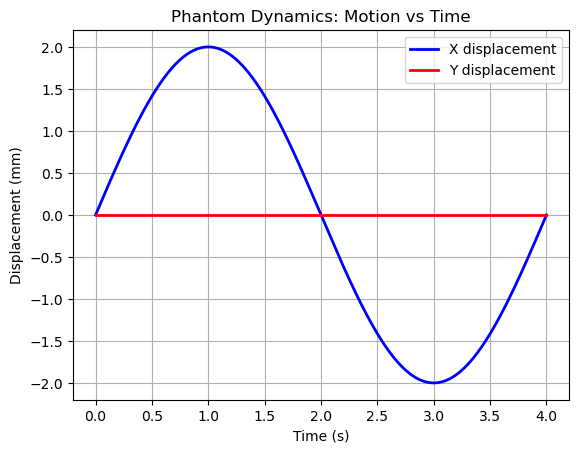

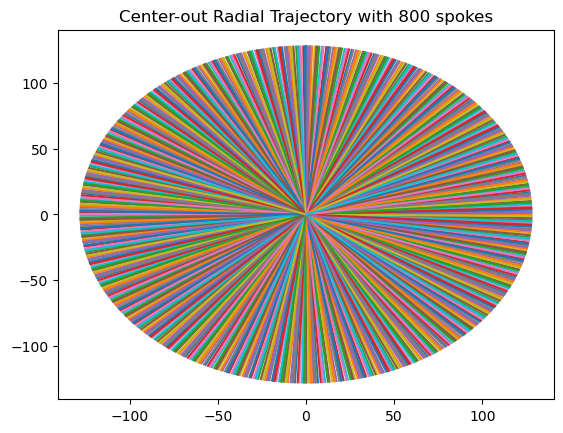

Processing spokes (with motion) on GPU: 100%|██████████| 800/800 [00:50<00:00, 15.73it/s]


Physical coords range: [-1.3, 1.3]
Pixel coords range: [-127.9, 127.9]
Normalized coordinates range: [-63.8761, 63.8761]
Expected pixel range: [-128.0, 128.0]
FOV used in forward encoding: 100.0
Max k-space coordinate: 63.8761 (1/mm)
coords_normalized range: [-63.876058, 63.876060]
Should be approximately: [-0.5, 0.5]
Density weights range: 0.000 to 1.279
K-space data range: -1.107e+03-3.867e+01j to 8.240e+03+0.000e+00j


In [9]:

# Usage:
if __name__ == "__main__":
    # Check GPU availability
    print(f"GPU available: {cp.cuda.is_available()}")
    print(f"GPU memory: {cp.get_default_memory_pool().used_bytes() / 1e9:.2f} GB")

radius = 20.
matrix_size = (256, 256)
matrix_size_3d = (1, 256, 256)
ntr = 800
nro = 1000
ndims = 2

## Set motion params to test
base_motion_params = {
                'amplitude' : 2,
                'frequency' : 0.25,
                'direction' :'x',
                'scan_time' : 4.0
                }


# Create original cylinder
cylinder_2d_mm, fov_mm, pos_mm, voxel_size_x = create_cylinder_with_objects_mm(radius, matrix_size_3d)
cylinder_orig = np.squeeze(cylinder_2d_mm)
show_2d_cylinder(cylinder_2d_mm)

# No Motion first
plot_motion_over_time(ntr, base_motion_params)

## Get radial coordinates
radial_coords_pixel, radial_coords_physical = center_out_GA_radial(ntr, nro, ndims, matrix_size,fov_mm)
plot_GA_trajectory(radial_coords_pixel)

# Perform Fourier encoding
S_radial_motion = fourier_encoding_radial_motion_gpu(radial_coords_physical, cylinder_2d_mm, fov_mm, 
                                                    upsamp=2, orig_size=256, motion_params=base_motion_params)
S_cartesian_motion = fourier_encoding_cartesian_motion_gpu(matrix_size, cylinder_2d_mm, fov_mm, 
                                                    upsamp=2, orig_size=256, motion_params=base_motion_params)

## Reconstruct with NUFFT and standard FFT
recon_image_radial = reconstruct_from_2d_radial(radial_coords_pixel, radial_coords_physical, S_radial_motion, 
                                             fov_mm, matrix_size)

recon_image_cartesian = reconstruct_from_2d_cartesian(S_cartesian_motion, matrix_size)

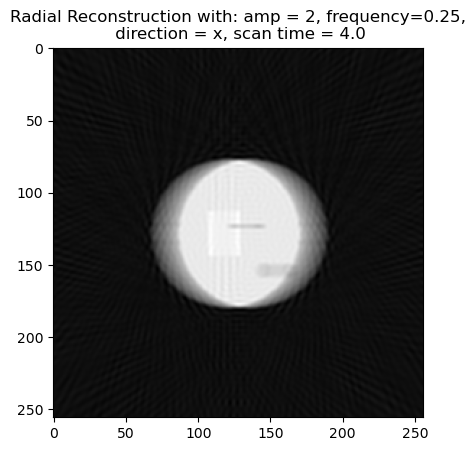

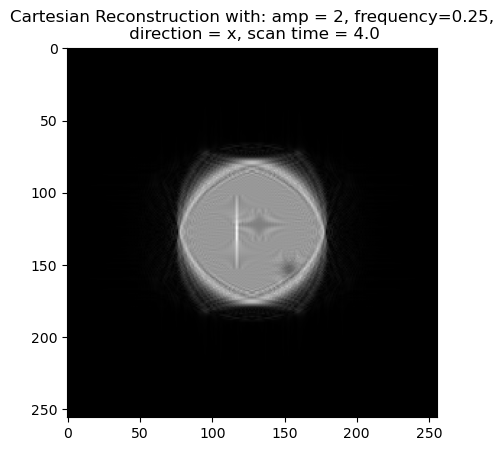

In [10]:
# ## Reconstruct with NUFFT and standard FFT
# recon_image_radial = reconstruct_from_2d_radial(radial_coords_pixel, radial_coords_physical, S_radial_motion, 
#                                              fov_mm, matrix_size)

radial_normalized = (recon_image_radial - recon_image_radial.min()) / (recon_image_radial.max() - recon_image_radial.min())

# recon_image_cartesian = reconstruct_from_2d_cartesian(S_cartesian_motion, matrix_size)
plt.figure(1)
plot_reconstruction(radial_normalized, motion_params=base_motion_params, recon_type='Radial')
plt.figure(2)
plot_reconstruction(recon_image_cartesian/(512**2), motion_params=base_motion_params, recon_type='Cartesian')

In [11]:
print(f"Original phantom range: [{cylinder_orig.min():.3f}, {cylinder_orig.max():.3f}]")
print(f"Cartesian recon range: [{recon_image_cartesian.min():.3f}, {recon_image_cartesian.max():.3f}]")
print(f"Radial recon range: [{recon_image_radial.min():.3f}, {recon_image_radial.max():.3f}]")

Original phantom range: [0.000, 1.500]
Cartesian recon range: [0.000, 1.342]
Radial recon range: [-660.630, 11172.593]


In [12]:
import pandas as pd

final_metrics_cartesian = calculate_image_metrics(cylinder_2d_mm, recon_image_cartesian)
final_metrics_radial = calculate_image_metrics(cylinder_2d_mm, recon_image_radial)

df = pd.DataFrame({'Cartesian': final_metrics_cartesian, 'Radial': final_metrics_radial})
print(df)


      Cartesian     Radial
mse    0.003033   0.012998
rmse   0.055076   0.114009
psnr  25.180791  18.861209
ssim   0.965438   0.767255
